In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'medium',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small',
         'lines.linewidth' : 1.6}
plt.rcParams.update(params)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_global = pd.read_csv('Global_mobility_Report.csv')
df_us = pd.read_csv('us.csv')

In [3]:
us = df_global[(df_global['country_region'] == 'United States') & (df_global['sub_region_1'].isna()) ]

In [4]:
us.shape

(210, 14)

In [5]:
us = us.drop(['country_region_code', 'country_region', 'sub_region_1', 
                   'sub_region_2', 'metro_area', 'iso_3166_2_code', 'census_fips_code'], axis = 1)
df_us = df_us.drop(['deaths'], axis = 1)

In [6]:
us['date'] = pd.to_datetime(us['date'])
df_us['date'] = pd.to_datetime(df_us['date'])

In [7]:
us.set_index('date', inplace = True)
df_us.set_index('date', inplace = True)

In [8]:
df_us['case_day'] = df_us['cases'].diff()
df_us['case_day'][0] = 1
df_us['case_day'] =  df_us['case_day'].astype('int')

### Merging both datasets to one

In [9]:
df = df_us.join(us, how='inner')

In [10]:
df.shape

(210, 8)

In [11]:
df.head()

,cases,case_day,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,
2020-02-15,15,0,6.0,2.0,15.0,3.0,2.0,-1.0
2020-02-16,15,0,7.0,1.0,16.0,2.0,0.0,-1.0
2020-02-17,25,10,6.0,0.0,28.0,-9.0,-24.0,5.0
2020-02-18,25,0,0.0,-1.0,6.0,1.0,0.0,1.0
2020-02-19,25,0,2.0,0.0,8.0,1.0,1.0,0.0


### Renaming columns

In [12]:
col = {'retail_and_recreation_percent_change_from_baseline': 'retail', 
      'grocery_and_pharmacy_percent_change_from_baseline': 'grocery',
      'parks_percent_change_from_baseline': 'parks',
      'transit_stations_percent_change_from_baseline': 'transit',
      'workplaces_percent_change_from_baseline' : 'workplace',
      'residential_percent_change_from_baseline': 'residential'}

In [13]:
df.rename(columns = col, inplace = True)

In [14]:
df.head()

,cases,case_day,retail,grocery,parks,transit,workplace,residential
date,,,,,,,,
2020-02-15,15,0,6.0,2.0,15.0,3.0,2.0,-1.0
2020-02-16,15,0,7.0,1.0,16.0,2.0,0.0,-1.0
2020-02-17,25,10,6.0,0.0,28.0,-9.0,-24.0,5.0
2020-02-18,25,0,0.0,-1.0,6.0,1.0,0.0,1.0
2020-02-19,25,0,2.0,0.0,8.0,1.0,1.0,0.0


In [15]:
df.tail()

,cases,case_day,retail,grocery,parks,transit,workplace,residential
date,,,,,,,,
2020-09-07,6317773,25173,-13.0,-4.0,107.0,-40.0,-71.0,16.0
2020-09-08,6346637,28864,-12.0,-1.0,52.0,-31.0,-38.0,9.0
2020-09-09,6379950,33313,-10.0,-3.0,58.0,-32.0,-36.0,9.0
2020-09-10,6417986,38036,-11.0,-2.0,61.0,-32.0,-36.0,9.0
2020-09-11,6465534,47548,-12.0,-5.0,69.0,-30.0,-34.0,8.0


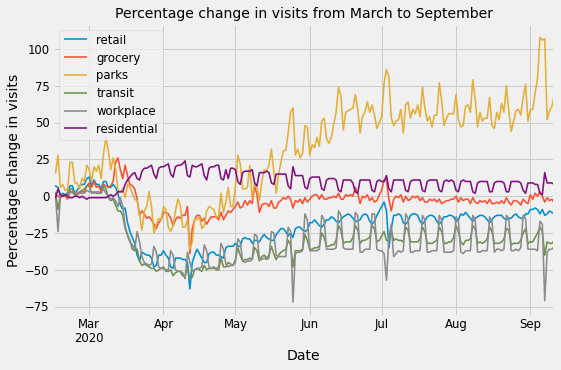

In [16]:
df[['retail', 'grocery', 'parks', 'transit', 'workplace', 'residential']].plot()
plt.xlabel('Date')
plt.ylabel('Percentage change in visits')
plt.title('Percentage change in visits from March to September')
plt.legend(fontsize = 'small')
plt.show()

Helper function to reduce the number of x_ticks

In [17]:
def helper_plot(n):
    every_nth = n
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)   

### Train Test Split

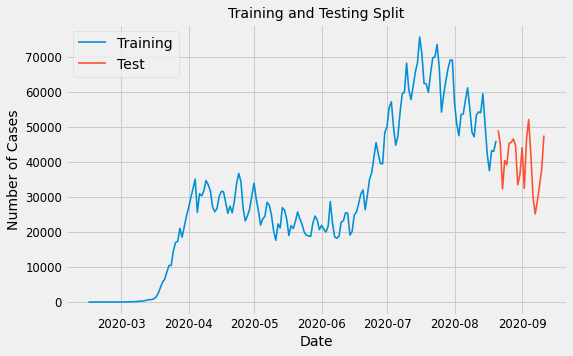

In [18]:
train = df.loc['2020-02-15':'2020-08-20']
test = df.loc['2020-08-21':]
fig, ax = plt.subplots()
plt.plot(train['case_day'], label = 'Training')
plt.plot(test['case_day'], label = 'Test')
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Training and Testing Split')
#helper_plot(60)
plt.show()

### ARIMAX model with Workplace percent as exogenous

In [19]:
workplace = SARIMAX(train['case_day'], 
                  exog = train['workplace'] , 
                  order=(7, 1, 6))
workplace_fit = workplace.fit(disp=False)

In [20]:
workplace_preds = workplace_fit.forecast(steps = 22, exog = test['workplace'])

In [21]:
workplace_preds

2020-08-21    47713.861929
2020-08-22    40569.043050
2020-08-23    34298.246491
2020-08-24    32560.003222
2020-08-25    34443.469794
2020-08-26    37778.885880
2020-08-27    42012.184379
2020-08-28    42566.011810
2020-08-29    36676.436419
2020-08-30    31856.275590
2020-08-31    30301.539742
2020-09-01    31808.012715
2020-09-02    35997.287378
2020-09-03    40082.862009
2020-09-04    40884.557589
2020-09-05    35791.603834
2020-09-06    31298.054558
2020-09-07    32439.020328
2020-09-08    31244.723264
2020-09-09    35308.858889
2020-09-10    39258.440961
2020-09-11    39877.925524
Freq: D, dtype: float64

In [22]:
workplace_rmse = np.sqrt(mean_squared_error(workplace_preds, test['case_day']))
print('Workplace RMSE: ', workplace_rmse)

Workplace RMSE:  5998.059739191115


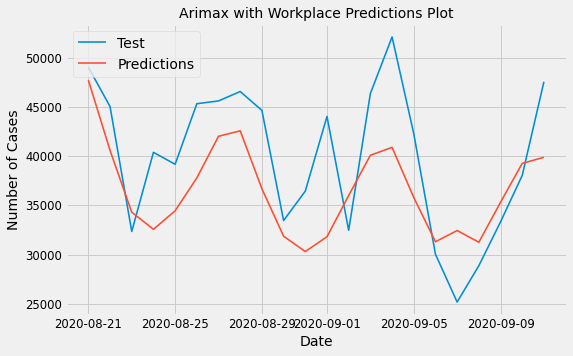

In [23]:
fig, ax = plt.subplots()
plt.plot(test['case_day'], label = 'Test')
plt.plot(workplace_preds, label  = 'Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(loc = 'upper left')
plt.title('Arimax with Workplace Predictions Plot')
plt.show()

### ARIMAX model with Residential percent as exogenous

In [24]:
residential = SARIMAX(train['case_day'], 
                  exog = train['residential'] , 
                  order=(7, 1, 6))
residential_fit = residential.fit(disp=False)

In [25]:
residential_preds = residential_fit.forecast(steps = 22, exog = test['residential'])

In [26]:
residential_preds

2020-08-21    47386.885568
2020-08-22    40304.093940
2020-08-23    34369.479804
2020-08-24    32712.600887
2020-08-25    34261.815191
2020-08-26    37696.290385
2020-08-27    41696.456185
2020-08-28    42135.067683
2020-08-29    36516.973495
2020-08-30    31299.299693
2020-08-31    29895.636425
2020-09-01    31375.209254
2020-09-02    35463.086220
2020-09-03    39057.111881
2020-09-04    39911.560244
2020-09-05    34547.674551
2020-09-06    29897.946084
2020-09-07    31164.942732
2020-09-08    30557.577469
2020-09-09    34713.577027
2020-09-10    38441.340735
2020-09-11    39057.600247
Freq: D, dtype: float64

In [27]:
residential_rmse = np.sqrt(mean_squared_error(residential_preds, test['case_day']))
print('Residential RMSE: ', residential_rmse)

Residential RMSE:  6259.044732323058


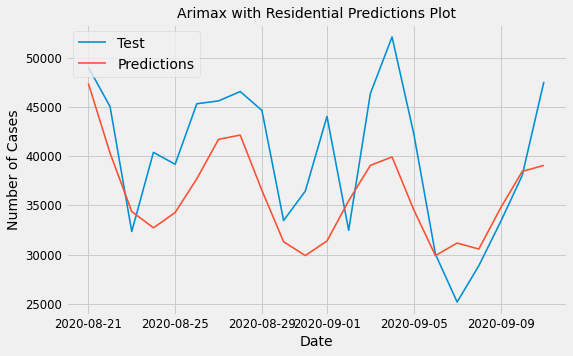

In [28]:
fig, ax = plt.subplots()
plt.plot(test['case_day'], label = 'Test')
plt.plot(residential_preds, label  = 'Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(loc = 'upper left')
plt.title('Arimax with Residential Predictions Plot')
plt.show()

### ARIMAX model with Parks percent as exogenous

In [29]:
parks = SARIMAX(train['case_day'], 
                  exog = train['parks'] , 
                  order=(7, 1, 6))
parks_fit = parks.fit(disp=False)

In [30]:
parks_preds = parks_fit.forecast(steps = 22, exog = test['parks'])

In [31]:
parks_preds

2020-08-21    48494.735517
2020-08-22    42006.840195
2020-08-23    33245.246398
2020-08-24    31751.259432
2020-08-25    35484.839213
2020-08-26    36835.880469
2020-08-27    40082.245749
2020-08-28    42472.707661
2020-08-29    37158.610582
2020-08-30    28488.189519
2020-08-31    27402.120850
2020-09-01    30788.821147
2020-09-02    32614.852050
2020-09-03    35702.021296
2020-09-04    38641.242304
2020-09-05    33811.215836
2020-09-06    25617.829325
2020-09-07    24496.910450
2020-09-08    27613.438313
2020-09-09    29496.361026
2020-09-10    32612.465584
2020-09-11    35650.952087
Freq: D, dtype: float64

In [32]:
parks_rmse = np.sqrt(mean_squared_error(parks_preds, test['case_day']))
print('Parks RMSE: ', parks_rmse)

Parks RMSE:  7160.736149891943


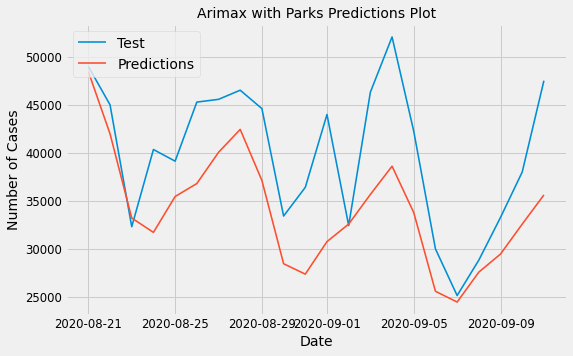

In [33]:
fig, ax = plt.subplots()
plt.plot(test['case_day'], label = 'Test')
plt.plot(parks_preds, label  = 'Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(loc = 'upper left')
plt.title('Arimax with Parks Predictions Plot')
plt.show()

### ARIMAX model with Transit percent as exogenous

In [34]:
transit = SARIMAX(train['case_day'], 
                  exog = train['transit'] , 
                  order=(7, 1, 6))
transit_fit = transit.fit(disp=False)

In [35]:
transit_preds = transit_fit.forecast(steps = 22, exog = test['parks'])

In [36]:
transit_preds

2020-08-21    42067.926142
2020-08-22    35172.889655
2020-08-23    27677.815850
2020-08-24    26456.602148
2020-08-25    29167.015055
2020-08-26    31019.201614
2020-08-27    34261.890633
2020-08-28    36996.277488
2020-08-29    31793.655420
2020-08-30    23078.062833
2020-08-31    22498.514642
2020-09-01    24699.905527
2020-09-02    27924.752053
2020-09-03    30557.292922
2020-09-04    32140.043493
2020-09-05    26339.618238
2020-09-06    19276.857895
2020-09-07    16338.777367
2020-09-08    22997.898432
2020-09-09    26160.358776
2020-09-10    29620.522287
2020-09-11    31196.555510
Freq: D, dtype: float64

In [37]:
transit_rmse = np.sqrt(mean_squared_error(transit_preds, test['case_day']))
print('Transit RMSE: ', transit_rmse)

Transit RMSE:  12184.2144383107


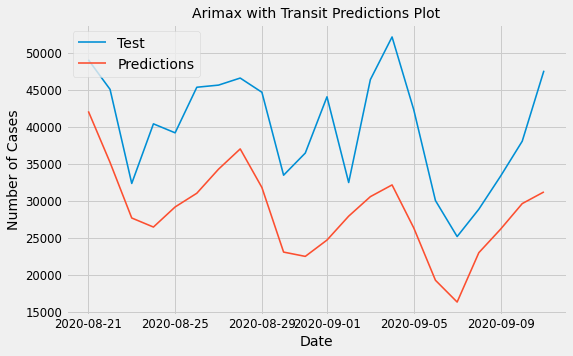

In [38]:
fig, ax = plt.subplots()
plt.plot(test['case_day'], label = 'Test')
plt.plot(transit_preds, label  = 'Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(loc = 'upper left')
plt.title('Arimax with Transit Predictions Plot')
plt.show()

### ARIMAX model with Grocery percent as exogneous

In [39]:
grocery = SARIMAX(train['case_day'], 
                  exog = train['grocery'] , 
                  order=(7, 1, 6))
grocery_fit = grocery.fit(disp=False)

In [40]:
grocery_preds = grocery_fit.forecast(steps = 22, exog = test['grocery'])

In [41]:
grocery_preds

2020-08-21    47351.534217
2020-08-22    41802.837351
2020-08-23    32265.973598
2020-08-24    30037.179709
2020-08-25    33976.595491
2020-08-26    36190.406841
2020-08-27    38465.730981
2020-08-28    40020.230936
2020-08-29    35160.054856
2020-08-30    26024.525250
2020-08-31    24093.640524
2020-09-01    28715.753680
2020-09-02    30898.255606
2020-09-03    34110.875496
2020-09-04    35850.179332
2020-09-05    31207.261116
2020-09-06    22226.570274
2020-09-07    19946.386587
2020-09-08    24310.486148
2020-09-09    26943.581934
2020-09-10    29916.755760
2020-09-11    31628.052082
Freq: D, dtype: float64

In [42]:
grocery_rmse = np.sqrt(mean_squared_error(grocery_preds, test['case_day']))
print('Grocery RMSE: ', grocery_rmse)

Grocery RMSE:  9203.987497642715


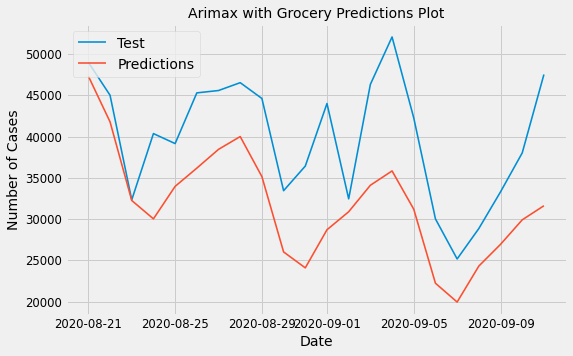

In [44]:
fig, ax = plt.subplots()
plt.plot(test['case_day'], label = 'Test')
plt.plot(grocery_preds, label  = 'Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(loc = 'upper left')
plt.title('Arimax with Grocery Predictions Plot')
plt.show()

### ARIMAX model with Retail percent as exogenous

In [51]:
retail = SARIMAX(train['case_day'], 
                  exog = train['retail'] , 
                  order=(7, 1, 6))
retail_fit = retail.fit(disp=False)

In [52]:
retail_preds = retail_fit.forecast(steps = 22, exog = test['retail'])

In [53]:
retail_preds

2020-08-21    48548.025453
2020-08-22    42252.832261
2020-08-23    33363.724577
2020-08-24    31584.437620
2020-08-25    35366.456993
2020-08-26    37241.801046
2020-08-27    40136.438385
2020-08-28    42633.372172
2020-08-29    37515.024508
2020-08-30    29183.368549
2020-08-31    27610.993269
2020-09-01    31230.842437
2020-09-02    33579.053322
2020-09-03    36788.656184
2020-09-04    39310.190697
2020-09-05    34578.998577
2020-09-06    26860.486114
2020-09-07    24915.499268
2020-09-08    28251.612662
2020-09-09    31032.158984
2020-09-10    34197.874158
2020-09-11    36666.641524
Freq: D, dtype: float64

In [54]:
retail_rmse = np.sqrt(mean_squared_error(retail_preds, test['case_day']))
print('Retail RMSE: ', retail_rmse)

Retail RMSE:  6695.513239354617


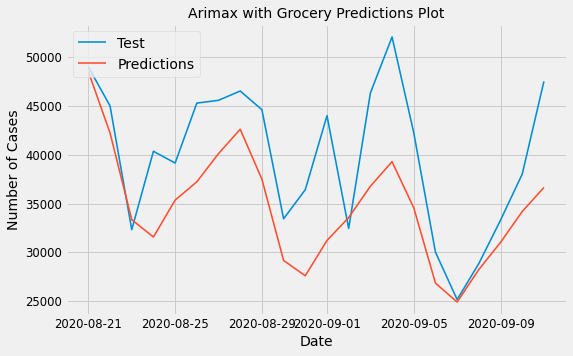

In [55]:
fig, ax = plt.subplots()
plt.plot(test['case_day'], label = 'Test')
plt.plot(retail_preds, label  = 'Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(loc = 'upper left')
plt.title('Arimax with Grocery Predictions Plot')
plt.show()

### Adding Multiple Exog

In [56]:
exog = np.array(train[['retail', 'grocery', 'parks', 'transit', 'workplace', 'residential']])

In [57]:
exog.shape

(188, 6)

In [73]:
model = SARIMAX(train['case_day'], 
                  exog = exog , 
                  order=(7, 1, 6))
model_fit = model.fit()

LinAlgError: LU decomposition error.